Importing required library and packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

Loading the MNIST fashion data

In [10]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding noise to original dataset images

In [24]:
noise_factor = 0.2
'''20% noise is added to images for performance evaluation of denoiser,
 it will be removed later and displayed with original images as reference
 '''
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plotting the image with and without added noise

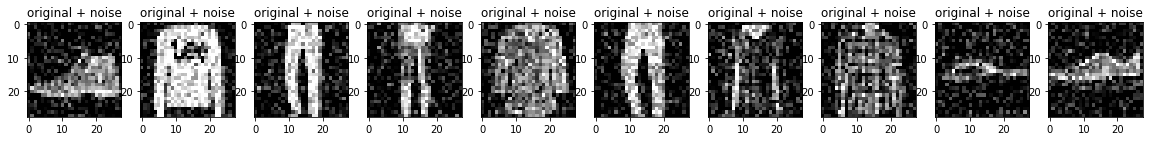

In [13]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

Creating a class to remove the added noise from the images

In [16]:
class Denoise(Model):
  ''' removing noise from noisy images also encoding already compressed images 
  to its previous size  '''
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [17]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [18]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 75s 40ms/step - loss: 0.0207 - val_loss: 0.0099
Epoch 2/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0091 - val_loss: 0.0087
Epoch 3/10
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 4/10
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 5/10
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 6/10
1875/1875 [==============================] - 70s 37ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 7/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0076 - val_loss: 0.0076
Epoch 8/10
1875/1875 [==============================] - 66s 35ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 9/10
1875/1875 [==============================] - 73s 39ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 10/10
1875/1875 [==============================] - 65s 35m

In [20]:
autoencoder.encoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 8)           1160      
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.decoder.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 8)         584       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [22]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Plotting both the noisy images and the denoised images produced by the autoencoder.

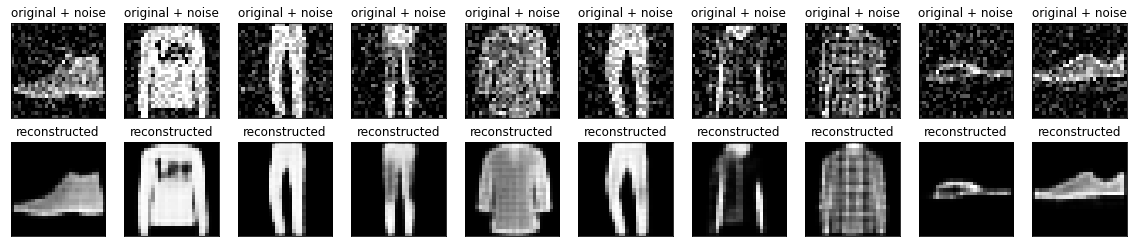

In [23]:
n = 10
plt.figure(figsize=(20, 4))
''' Both noisy and denoised images are displayed together'''
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()